In [1]:
savefig = True

if savefig:
    from analysis_module import os, plot, ANALYSIS_PATH  # for saving figures

    FIG_PATH = os.path.join(ANALYSIS_PATH, plot.FIG_PATH)
    figID = 3

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from neuron import h
from bmtool.singlecell import Profiler, Passive, CurrentClamp, FI, ZAP

Cell = 'FSI_Cell'

if 'plot' in globals():
    linecolor = plot.pop_color[next(p for p in plot.pop_names if p in Cell)]
else:
    linecolor = 'b'

mechanisms_dir = '../components/mechanisms'
template_dir = '../components/templates'

profiler = Profiler(template_dir=template_dir, mechanism_dir=mechanisms_dir, dt = 0.05)

def run_and_plot(sim, title, xlabel, ylabel, plot=True, plot_injection_only=False, time_offset=False):
    X, Y = sim.execute()
    X = np.array(X)
    Y = np.array(Y)
    if plot:
        fig = plt.figure(figsize=(5, 3))
        if plot_injection_only:
            t_idx = (X >= sim.inj_delay) & (X <= sim.inj_delay + sim.inj_dur)
            x = X[t_idx]
            if time_offset:
                x -= x[0]
            plt.plot(x, Y[t_idx], color=linecolor)
        else:
            plt.plot(X, Y, color=linecolor)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    return X, Y, fig

In [3]:
noise = False
post_init_function = 'insert_mechs(0)' if noise else None

# CP cell settings
basic_settings = {
    'Passive': {
        'celsius': 26.,
        'kwargs': {
            'inj_amp': -100.,
            'inj_delay': 1500.,
            'inj_dur': 1000.,
            'tstop': 2500.,
            'method': 'exp2'
        }
    },
    'CurrentClamp': {
        'celsius': 34.,
        'kwargs': {
            'post_init_function': post_init_function,
            'inj_amp': 350.,
            'inj_delay': 1500.,
            'inj_dur': 1000.,
            'tstop': 3000.,
            'threshold': 0.
        }
    },
    'ZAP': {
        'celsius': 34.,
        'kwargs': {
            'post_init_function': post_init_function,
            'inj_amp': 100.,
            'inj_delay': 1000.,
            'inj_dur': 15000.,
            'tstop': 15500.,
            'fstart': 0.,
            'fend': 15.,
            'chirp_type': 'linear'
        }
    },
    'FI': {
        'celsius': 34.,
        'kwargs': {
            'post_init_function': post_init_function,
            'i_start': 0.,
            'i_stop': 1000.,
            'i_increment': 50.,
            'tstart': 1500.
        }
    }
}
Cell_settings = {cell: deepcopy(basic_settings) for cell in ['CP_Cell', 'CS_Cell', 'FSI_Cell', 'LTS_Cell']}

# CS cell settings
settings = Cell_settings['CS_Cell']
settings['CurrentClamp']['kwargs']['inj_amp'] = 300.

# FSI cell settings
settings = Cell_settings['FSI_Cell']
settings['Passive']['celsius'] = 30.
settings['Passive']['kwargs'] = {'inj_amp': -100., 'inj_delay': 500., 'inj_dur': 500., 'tstop': 1100., 'method': 'exp2'}
settings['CurrentClamp']['celsius'] = 21.
settings['CurrentClamp']['kwargs'] = {'inj_amp': 200., 'inj_delay': 500., 'inj_dur': 500., 'tstop': 1100., 'threshold': 0.}
settings['ZAP']['celsius'] = 30.
settings['ZAP']['kwargs']['inj_amp'] = 10.
settings['FI']['celsius'] = 30.
settings['FI']['kwargs']['tstart'] = 500.
# settings['Passive'] = None
# settings['ZAP'] = None
# settings['FI'] = None

# LTS cell settings
settings = Cell_settings['LTS_Cell'] = deepcopy(Cell_settings['FSI_Cell'])
settings['CurrentClamp']['kwargs']['inj_amp'] = 50. 

In [4]:
settings = Cell_settings[Cell]


#### Passive Properties

In [5]:
proc = settings['Passive']
if proc is not None:
    h.celsius = proc['celsius']
    sim = Passive(Cell, **proc['kwargs'])
    title = 'Passive Cell Current Injection'
    xlabel = 'Time (ms)'
    ylabel = 'Membrane Potential (mV)'

Injection location: FSI_Cell[0].soma[0](0.5)
Recording: FSI_Cell[0].soma[0](0.5)._ref_v


Running simulation for passive properties...

V Rest: -69.94 (mV)
Resistance: 223.12 (MOhms)
Membrane time constant: 12.03 (ms)

V_rest Calculation: Voltage taken at time 500.0 (ms) is
-69.94 (mV)

R_in Calculation: dV/dI = (v_final-v_rest)/(i_final-i_start)
(-92.26 - (-69.94)) / (-0.1 - 0)
22.31 (mV) / 0.1 (nA) = 223.12 (MOhms)

Tau Calculation: Fit a double exponential curve to the membrane potential response
f(t) = a0 + a1*exp(-t/tau1) + a2*exp(-t/tau2)
Constained by initial value: f(0) = a0 + a1 + a2 = v_rest
Fit parameters: (a0, a1, a2, tau1, tau2) = (-92.26, 22.20, 0.11, 12.03, 0.02)
Membrane time constant is determined from the slowest exponential term: 12.03 (ms)

Sag potential: v_sag = v_peak - v_final = 0.00 (mV)
Normalized sag potential: v_sag / (v_peak - v_rest) = -0.000



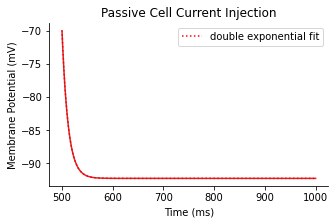

In [6]:
if proc is not None:
    if sim.method == 'exp2':
        X, Y, fig = run_and_plot(sim, title, xlabel, ylabel, plot_injection_only=True)
        plt.gca().plot(*sim.double_exponential_fit(), 'r:', label='double exponential fit')
        plt.legend()
    else:
        X, Y, fig = run_and_plot(sim, title, xlabel, ylabel, plot_injection_only=True)
    plt.show()

#### Current Injection

In [7]:
proc = settings['CurrentClamp']
if proc is not None:
    h.celsius = proc['celsius']
    sim2 = CurrentClamp(Cell, **proc['kwargs'])
    title = 'Current Injection'
    xlabel = 'Time (ms)'
    ylabel = 'Membrane Potential (mV)'

Injection location: FSI_Cell[1].soma[0](0.5)
Recording: FSI_Cell[1].soma[0](0.5)._ref_v


Current clamp simulation running...

Number of spikes: 81



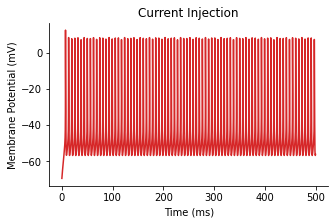

In [8]:
if proc is not None:
    X, Y, fig = run_and_plot(sim2, title, xlabel, ylabel, plot_injection_only=True, time_offset=True)
    plt.show()

In [9]:
if savefig:
    ax = fig.axes[0]
    ax.set_xlim(left=0.)
    plot.savefig(fig, 'Fig1_B' + str(figID), dir=FIG_PATH)

#### Impedance Amplitude Profile (ZAP)

In [10]:
proc = settings['ZAP']
if proc is not None:
    h.celsius = proc['celsius']
    sim3 = ZAP(Cell, **proc['kwargs'])
    title = 'ZAP Response'
    xlabel = 'Time (ms)'
    ylabel = 'Membrane Potential (mV)'

Injection location: FSI_Cell[2].soma[0](0.5)
Recording: FSI_Cell[2].soma[0](0.5)._ref_v


ZAP current simulation running...

Chirp current injection with frequency changing from 0 to 15 Hz over 15 seconds
Impedance is calculated as the ratio of FFT amplitude of membrane voltage to FFT amplitude of chirp current

Resonant Peak Frequency: 0.8 (Hz)


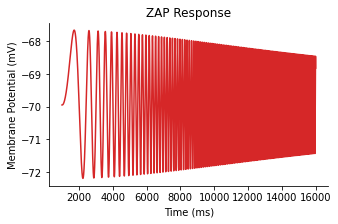

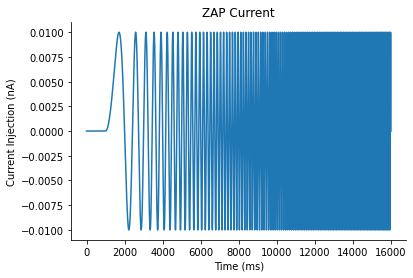

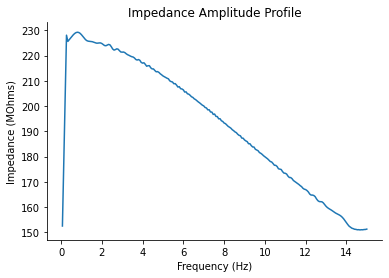

In [11]:
if proc is not None:
    X, Y, fig = run_and_plot(sim3, title, xlabel, ylabel, plot_injection_only=True)

    plt.figure()
    plt.plot(X, sim3.zap_vec)
    plt.title('ZAP Current')
    plt.xlabel('Time (ms)')
    plt.ylabel('Current Injection (nA)')

    plt.figure()
    plt.plot(*sim3.get_impedance(smooth=9))
    plt.title('Impedance Amplitude Profile')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Impedance (MOhms)')
    plt.show()

#### F-I Curve

In [12]:
proc = settings['FI']
if proc is not None:
    h.celsius = proc['celsius']
    sim4 = FI(Cell, **proc['kwargs'])
    title = 'FI Curve'
    xlabel = 'Current injection (nA)'
    ylabel = 'Number of spikes'

Injection location: FSI_Cell[22].soma[0](0.5)
Recording: FSI_Cell[22].soma[0](0.5)._ref_v


Running simulations for FI curve...

Results
Injection (nA): 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95
Number of spikes: 0, 27, 91, 131, 162, 188, 210, 230, 247, 263, 277, 291, 303, 315, 326, 337, 206, 2, 1, 1



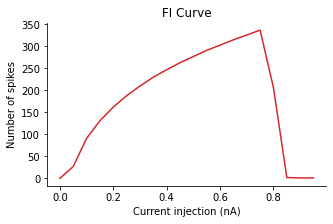

In [13]:
if proc is not None:
    X, Y, fig = run_and_plot(sim4, title, xlabel, ylabel)
    plt.show()

In [14]:
if savefig:
    ax = fig.axes[0]
    ax.set_xlim(left=0.)
    ax.set_ylim(bottom=0.)
    nspk = ax.get_yticks()
    ax.set_yticks(nspk)
    ax.set_yticklabels(1000 * nspk / sim4.tdur)
    ax.set_ylabel('Frequency (Hz)')

    plot.savefig(fig, 'Fig1_C' + str(figID), dir=FIG_PATH)